In [55]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
train_dataset_fp = pd.read_csv('iris_training.csv')
train_dataset_fp

,sepal_length,sepal_width,petal_length,petal_width,species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0
...,...,...,...,...,...
115,5.5,2.6,4.4,1.2,1
116,5.7,3.0,4.2,1.2,1
117,4.4,2.9,1.4,0.2,0
118,4.8,3.0,1.4,0.1,0


In [57]:
# 数据集
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_dataset_fp.iloc[:, :4].values, train_dataset_fp.iloc[:, 4].values))
train_dataset = train_dataset.batch(32)

In [58]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

In [59]:
# 自定义模型训练过程(类似pytorch)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
train_loss_results = []
train_accuracy_results = []


def loss(model, x, y, training):
    y_ = model(x, training=training)
    return loss_object(y_true=y, y_pred=y_)


def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


num_epochs = 301

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y)  # 梯度计算
        optimizer.apply_gradients(zip(grads, model.trainable_variables))  # 执行一次优化步骤

        # 累计;不需要进行reset_state
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        epoch_accuracy.update_state(y, model(x, training=True))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))

Epoch 000: Loss: 1.450, Accuracy: 46.667%
Epoch 050: Loss: 0.384, Accuracy: 94.167%
Epoch 100: Loss: 0.257, Accuracy: 96.667%
Epoch 150: Loss: 0.190, Accuracy: 96.667%
Epoch 200: Loss: 0.154, Accuracy: 95.833%
Epoch 250: Loss: 0.133, Accuracy: 95.833%
Epoch 300: Loss: 0.120, Accuracy: 96.667%


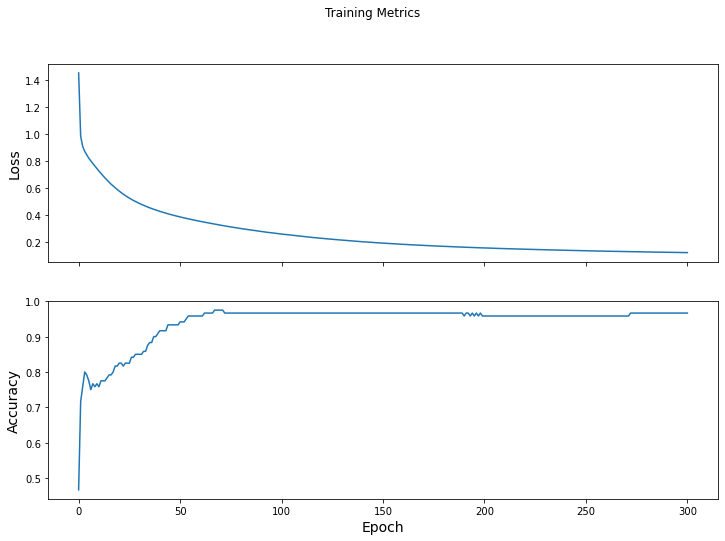

In [60]:
# 可视化

fig, axes = plt.subplots(2, sharex='all', figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [61]:
# 预测

class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5, ],
    [5.9, 3.0, 4.2, 1.5, ],
    [6.9, 3.1, 5.4, 2.1]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100 * p))

Example 0 prediction: Iris setosa (99.0%)
Example 1 prediction: Iris versicolor (97.0%)
Example 2 prediction: Iris virginica (66.7%)
